# Stock Price Prediction From Employee / Job Market Information
## Data Load and Initial EDA
Objective utilise the Thinknum LinkedIn and Job Postings datasets, along with the Quandl WIKI prices dataset to investigate the effect of hiring practices on stock price. Investigate whether hiring practices are a lagging or leading indicator for a number of stocks.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from glob import glob

# Utilities
from utils import *

%matplotlib inline
PATH = Path('D:\data\jobs')

## 1. LinkedIn
Datasource: [Thinknum](https://www.thinknum.com/) [linkedIn dataset](https://blog.thedataincubator.com/tag/data-sources/)

In [ ]:
link = pd.read_csv(PATH/'temp_datalab_records_linkedin_company.csv',
                   parse_dates=['as_of_date','date_added','date_updated'],
                   index_col='as_of_date')

Plot a few companies from the dataset.

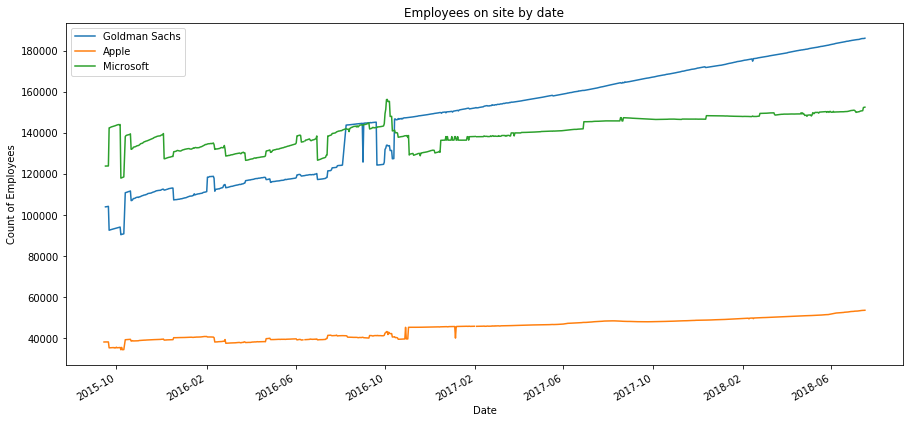

In [4]:
selected = link.query('(company_name == "Goldman Sachs") or (company_name == "Apple") or (company_name == "Microsoft")')\
        [['company_name','employees_on_platform']].pivot(columns='company_name')
selected.plot(figsize=(15,7))
plt.title('Employees on site by date');
plt.legend(('Goldman Sachs','Apple','Microsoft'));
plt.xlabel('Date');
plt.ylabel('Count of Employees');

In [5]:
print('Number of companies in dataset: ' + str(len(link.dataset_id.unique())))
print('Min and max date in dataset: {},{}'.format(link.index.min(),link.index.max()))

Number of companies in dataset: 4610
Min and max date in dataset: 2015-09-14 00:00:00,2018-07-17 00:00:00


It looks like we have almost 5000 unique companies and data spaning September 2015 to mid July 2017. 

## 2. Stock Ticker Information
In order to link company names and stock ticker information I found files on the NASDAQ exchange website containing full listing information for the [NASDAQ](https://www.nasdaq.com/screening/companies-by-name.aspx?letter=0&exchange=nasdaq&render=download), [NYSE](https://www.nasdaq.com/screening/companies-by-name.aspx?letter=0&exchange=nyse&render=download), and [AMEX](https://www.nasdaq.com/screening/companies-by-name.aspx?letter=0&exchange=amex&render=download) exchanges. I combined them into a single file `companylist_ALL.csv` and did some manual data cleaning to link company names to stock symbols.

In [6]:
sym = pd.read_csv(PATH/'companylist_ALL.csv',index_col=0)

In [7]:
# All unique IDs and Company names
companies = link.groupby(['dataset_id','company_name'])['link'].count().reset_index()
companies['clean_name'] = clean_name(companies.company_name) #Use name cleaning heuristic to increase matches

# Merge on clean_name column
companies = companies.merge(sym,how='inner',on='clean_name')
companies = companies.groupby(['dataset_id','company_name']).first().reset_index() #keep first of each name
companies.drop(['link','Unnamed: 0.1','Unnamed: 8'],axis=1, inplace=True)
companies.head(3)

,dataset_id,company_name,clean_name,IPOyear,LastSale,MarketCap,Name,Sector,Summary Quote,Symbol,industry
0,58329,Goldman Sachs,goldman sachs,1999.0,214.01,$80.8B,"Goldman Sachs Group, Inc. (The)",Finance,https://www.nasdaq.com/symbol/gs,GS,Investment Bankers/Brokers/Service
1,58362,Microsoft,microsoft,1986.0,108.30,$831.47B,Microsoft Corporation,Technology,https://www.nasdaq.com/symbol/msft,MSFT,Computer Software: Prepackaged Software
2,58363,United Technologies,united technologies,NaN,124.40,$99.53B,United Technologies Corporation,Capital Goods,https://www.nasdaq.com/symbol/utx,UTX,Aerospace


In [22]:
print('Number of companies linked: '+str(len(companies)))

Number of companies linked: 2011


Just under half of the companies were linked to a stock symbol using basic string cleaning and some initial data munging. This should be enough for initial analysis.

## 3. Stock Price Data

In [8]:
# Data source: https://www.quandl.com/databases/WIKIP
stocks = pd.read_csv(PATH/'WIKI_PRICES.csv')

# Fast clean dates
stocks['date'] = parse_dates(stocks.date)
stocks = stocks.set_index('date')

# Select on the adjusted close column
close = stocks[['ticker','adj_close']].pivot(columns='ticker')
close.columns = close.columns.droplevel(0)
del stocks

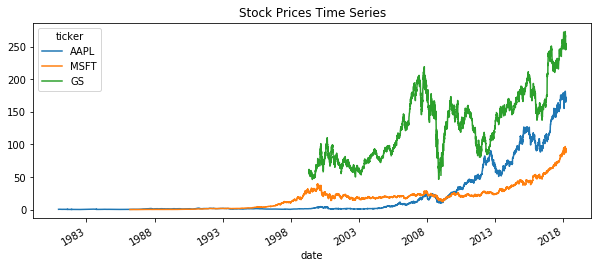

In [15]:
# Plot some example series
close[['AAPL','MSFT','GS']].plot(figsize=(10,4))
plt.title('Stock Prices Time Series');

## Investigating the correlation between Stock Price and Employee Count
I'm using the cross correlation of the two series to investigate how they are related, for each stock I will find the optimal time lag that maximises the series correlations.  

**This will indicate:**
1. How well the series are correlated
2. Whether employee count is predictice of stock price or the other way around

Note: A negative lag value here indicates *employee count leads the stock data*, while a positive lag value indicates *stock data leads employee count*.

In [17]:
# import helper functions
from cross_correlation import cross_correlation_plot, correlation

GS Goldman Sachs
Max correlation at t=0
Max correlation:0.9090720593390305


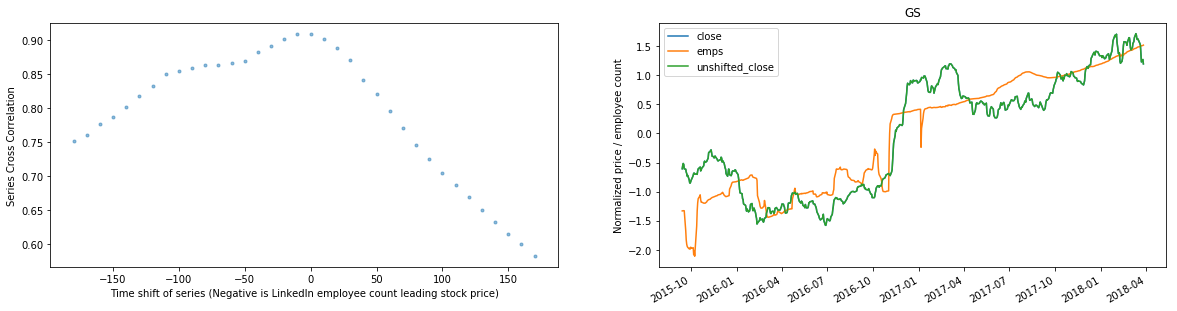

MSFT Microsoft
Max correlation at t=170
Max correlation:0.798022458728359


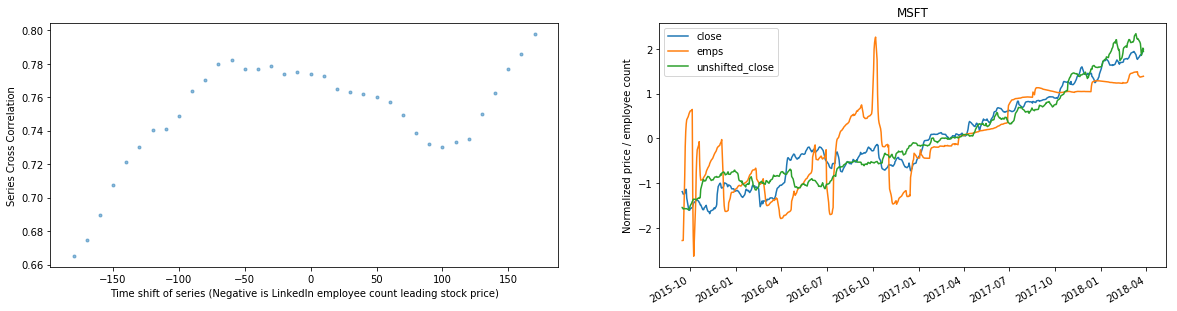

UTX United Technologies
Max correlation at t=170
Max correlation:0.11804771512609726


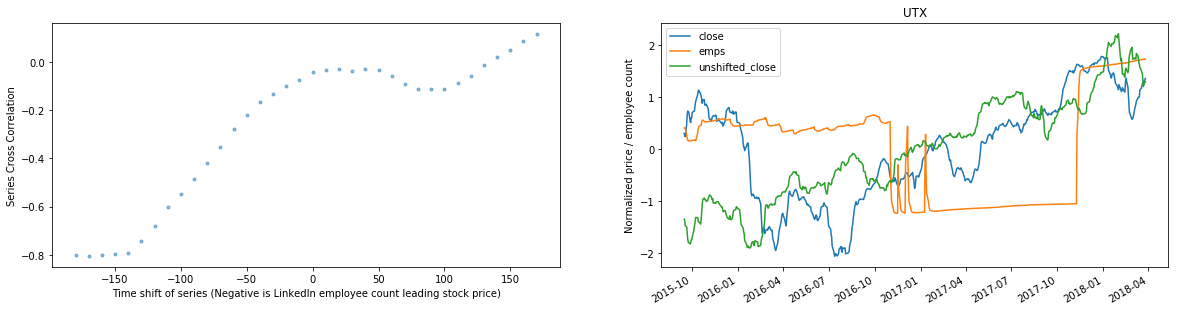

In [21]:
sample = companies.head(3).copy()

cors = np.full(len(sample),np.nan)
lags = np.full(len(sample),np.nan)
cord = {}

for i,x in enumerate(sample.iterrows()):
    print(x[1].Symbol,x[1].company_name)
    did = x[1].dataset_id
    sym = x[1].Symbol
    
    try:
        ticker = close[sym]
        emps = link[link['dataset_id'] == did]['employees_on_platform']
    except:
        print("Can't compute correlation")
        continue

    
    df,l,c,cd = cross_correlation_plot(ticker,emps,srange=(-180,180),smoothing=3, plot=True, resolution=10)
    plt.show()
    
    cors[i] = c
    lags[i] = l
    cord[i] = cd
    
sample['max_corr'] = cors
sample['best_lag'] = lags

Observations about the above plots:

| Symbol | Company | Comment |
| ----------- | ----------- | ----------- |
| GS | Goldman Sachs | High maximum correlation with no time lag, suggesting the employee count and stock price are well correlated, but employee count may not predict stock price that well (lower correlation at negative lags).|
| MSFT | Microsoft | Some correlation in general trend of the series. The Employee data is quite erratic. |
| UTX | United Technologies | Low correlation between the series. Low predictive power. |

### Evaluating statistics for all companies
I then ran the above for all of the remaining stock symbols in the `companies` DataFrame, and saved to a .csv.

In [2]:
correlations = pd.read_csv(PATH/'extracted_correlations_all.csv')

In [3]:
correlations['log_cap'] = correlations.MarketCap.apply(parse_currency).apply(np.log)
correlations['ipoyr_fill'] = correlations.IPOyear.fillna(correlations.IPOyear.median())
# correlations['log_cap'] = (correlations.log_cap - correlations.log_cap.mean()) / correlations.log_cap.std()

In [11]:
from bokeh.plotting import figure, show, output_notebook
output_notebook()

Loading BokehJS ...

In [63]:
from bokeh.palettes import brewer, Viridis256
from bokeh.transform import linear_cmap
from bokeh.models import ColumnDataSource
from bokeh.models import HoverTool

source = ColumnDataSource(correlations)
colors = linear_cmap(field_name='IPOyear',palette=Viridis256, low=1980,high=2018)

TOOLS="hover, box_zoom,reset,tap,save,box_select,poly_select,lasso_select"
p1 = figure(title="Optimal Correlation and Timeshift Parameters", toolbar_location="above",
            width=900, height=500, tools=TOOLS)

p1.circle(x='best_lag', y = 'max_corr', source=source, fill_color=colors,
           fill_alpha=0.9, line_color=None, size=13)

hover = p1.select(dict(type=HoverTool))
hover.tooltips = [
        ("Name", "@Name"),
        ("IPO Year", "@IPOyear"),
        ("Correlation", "@max_corr"),
        ("Optimal Lag", "@best_lag"),
        ]


show(p1)

ValueError: expected an instance of type ContinuousColorMapper, got {'field': 'IPOyear', 'transform': LinearColorMapper(id='4766', ...)} of type dict

- **Middle Band** (abs(correlations) < 0.8): Low evidence of correlation between series.
- **Upper Left Quadrant**: Employee count may be predictive of stock value in the future.
- **Upper Right Quadrant**: Evidence that employee count reacts to stock price movement.
- **Bottom Left Quadrant**: Increase in employee count in past, correlates with a decrease in stock prices in the future.
- **Bottom Right Quadrant**: Increase in stock price correlated with a decrease in employee count in future.

In [61]:
# Also plotted in plotly (not displayed in github)
import plotly
import plotly.graph_objs as go

plotly.offline.init_notebook_mode(connected=True)

data = go.Scatter(
    x = correlations.best_lag,
    y = correlations.max_corr,
    mode='markers',
    marker = dict(
        size = 12,
        color = correlations.ipoyr_fill,
        colorscale='Viridis',
        showscale=True,
    ),
    text = list(zip(correlations.company_name,correlations.IPOyear))
)

layout= go.Layout(
    title= 'Optimal Correlation and Timeshift Parameters',
    hovermode= 'closest',
    showlegend= False,
    xaxis=dict(
        title = 'Timeshift, days (negative: employee count leads stock price; positive: stocks lead employee count)'
    ),
    yaxis=dict(
        title = 'Series correlations',
    ),
)

fig = go.Figure(data=[data], layout=layout)
plotly.offline.iplot(fig);

- **Middle Band** (abs(correlations) < 0.8): Low evidence of correlation between series.
- **Upper Left Quadrant**: Employee count may be predictive of stock value in the future.
- **Upper Right Quadrant**: Evidence that employee count reacts to stock price movement.
- **Bottom Left Quadrant**: Increase in employee count in past, correlates with a decrease in stock prices in the future.
- **Bottom Right Quadrant**: Increase in stock price correlated with a decrease in employee count in future.